In [2]:
import torch
import torch.optim as optim
import torchvision
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random
from datetime import datetime

In [3]:
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage import io

In [15]:
# Modify the loss function to ignore NaN values

# def factorize(A, k, device=torch.device("cpu")):

#     A = A.to(device)
#     # Randomly initialize A and B
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)
#     mask = ~torch.isnan(A)

#     descent_metrics = []
#     for i in range(5000):
#         diff_matrix = torch.mm(W, H) - A
#         diff_vector = diff_matrix[mask]
#         loss = torch.norm(diff_vector)

#         optimizer.zero_grad()

#         loss.backward()

#         optimizer.step()
#         if i == 0:
#           descent_metrics.append([i,loss])
#         if ((i+1) % 100) == 0:
#           descent_metrics.append([i+1,loss])

#     return W, H, loss, descent_metrics

def factorize(A,k,device= torch.device("cpu")):
  A = A.to(device)
  A = A.to(torch.float32)
  dtype = A.dtype

  W = torch.randn(A.shape[0], k, requires_grad=True, device=device, dtype=torch.float32)
  H = torch.randn(k, A.shape[1], requires_grad=True, device=device, dtype=torch.float32)
  mask = ~torch.isnan(A)

  for i in range (1000):
    for j in range(H.shape[1]):
      mask_rows= ~torch.isnan(A[:,j])
      h_j = torch.linalg.lstsq(W[mask_rows], A[:,j][mask_rows]).solution
      with torch.no_grad():
        H[:,j]=h_j
    Aprime=A.t()
    Wprime=W.t()
    Hprime=H.t()
    for j in range(Wprime.shape[1]):
      mask_rows= ~torch.isnan(Aprime[:,j])
      w_j = torch.linalg.lstsq(Hprime[mask_rows], Aprime[:, j][mask_rows]).solution
      with torch.no_grad():
        Wprime[:,j] = w_j
    w=Wprime.t()
    # if i%100==0:
      # print (f"epoch {i}")

  return W,H

In [5]:
def factorize_color(A, k, device,timestamp_string, plot_loss=False, save_each_channel= False):
  w =[]
  h =[]
  l =[]
  gd =[]
  im = []
  #three seperate factorization for three channels
  for channel in range(3):
    w1,h1= factorize(A[channel],k,device)
    w.append(w1)
    h.append(h1)
    # l.append(loss1)
    # gd.append(descent1)
  #generate full individual channel
  for i in range(3):
    im.append(torch.mm(w[i], h[i]).cpu().detach().numpy())

  #combine the channels and save output
  bgr = cv2.merge([im[2],im[1],im[0]])
  filelocation = "/content/"+timestamp_string+".jpg"
  cv2.imwrite(filelocation, bgr)
  return gd

In [6]:
if os.path.exists("/content/dog.jpg"):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Load the image
img = torchvision.io.read_image("/content/dog.jpg")
print(img.shape)

--2024-03-06 09:33:06--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 99.84.203.111, 99.84.203.76, 99.84.203.80, ...
Connecting to segment-anything.com (segment-anything.com)|99.84.203.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-03-06 09:33:07 (9.14 MB/s) - ‘dog.jpg’ saved [221810/221810]

torch.Size([3, 1365, 2048])


In [7]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)

In [8]:
def remove_block_from_image(img, start_row, end_row, start_col, end_col):
    img_copy = img.clone()
    img_copy[start_row:end_row, start_col:end_col] = float('nan')
    return img_copy

def remove_block_from_color_image(img, start_row, end_row, start_col, end_col):
    masked_imgs = []
    for channel in range(3):
        channel_img = img[channel, :, :]
        channel_img = torch.tensor(channel_img, dtype=torch.float)
        masked_channel_img = remove_block_from_image(channel_img, start_row, end_row, start_col, end_col)
        masked_imgs.append(masked_channel_img)
    masked_img = torch.stack(masked_imgs, dim=0)
    return masked_img

# Reconstruction of 30x30 block missing image in three parts:
- Area with mainly single color
- Area with 2-3 colors
- Area with at least 5 diffent colors

In [9]:
def run_for_various_masks(crop, areas):
  descent_collection = []
  original_image = ""
  reconstructed_images = []
  for area in areas:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    timestamp_string = datetime.now().strftime("%Y%m%d%H%M%S")
    original_image = timestamp_string+"_original.jpg"
    to_pil = torchvision.transforms.ToPILImage()
    pil_image = to_pil(crop)

    output_path = "/content/"+original_image
    pil_image.save(output_path)
    image = cv2.imread(output_path)

    start_row, end_row, start_col, end_col = area

    patch_color = (0, 0, 0)
    patch = np.zeros((end_row - start_row, end_col - start_col, 3), dtype=np.uint8)
    patch[:, :] = patch_color

    image[start_row:end_row, start_col:end_col, :] = patch

    img_np = crop.permute(1, 2, 0).numpy()  # Permute channels for proper visualization

    # Display the image using plt.imshow
    # plt.imshow(img_np)
    # plt.axis('on')  # Optional: Turn off axis labels
    # plt.show()

    axes[0].imshow(img_np)
    axes[0].axis('off')  # Turn off axis labels for better visualization
    axes[0].set_title('Original Image')


    axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title('Masked Image')

    masked_img = remove_block_from_color_image(crop, start_row, end_row, start_col, end_col)

    timestamp_string = datetime.now().strftime("%Y%m%d%H%M%S")

    gds = factorize_color(masked_img, 40, torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), timestamp_string)
    descent_collection.append(gds)

    output_image_filename = timestamp_string+".jpg"
    read_location = "/content/"+ output_image_filename
    reconstructed_images.append(output_image_filename)
    img = torchvision.io.read_image(read_location)
    img_np = img.permute(1, 2, 0).numpy()  # Permute channels for proper visualization

    # Display the image using plt.imshow
    axes[2].imshow(img_np)
    axes[2].axis('off')  # Optional: Turn off axis labels
    axes[2].set_title('Reconstructed Image')
    plt.title(f"{area[1]-area[0]}x{area[3]-area[2]} patch removed")
    plt.tight_layout()

    # Show the plot
    plt.show()
  return descent_collection, original_image, reconstructed_images

In [ ]:
# areas = [[20, 40, 30, 50],[90, 110, 40, 60],[190, 210, 50, 70],
#          [10, 50, 20, 60],[80, 120, 30, 70],[180, 220, 40, 80],
#          [0, 60, 10, 70],[60, 120, 20, 80],[160,220,30,90],
#          [0,80,0,80],[60,140,20,100],[160,240,30,110]
#          ]

areas = [[20, 40, 30, 50]]
gds, original_image, reconstructed_images = run_for_various_masks(crop, areas)

<ipython-input-8-de69a6075272>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel_img = torch.tensor(channel_img, dtype=torch.float)


12


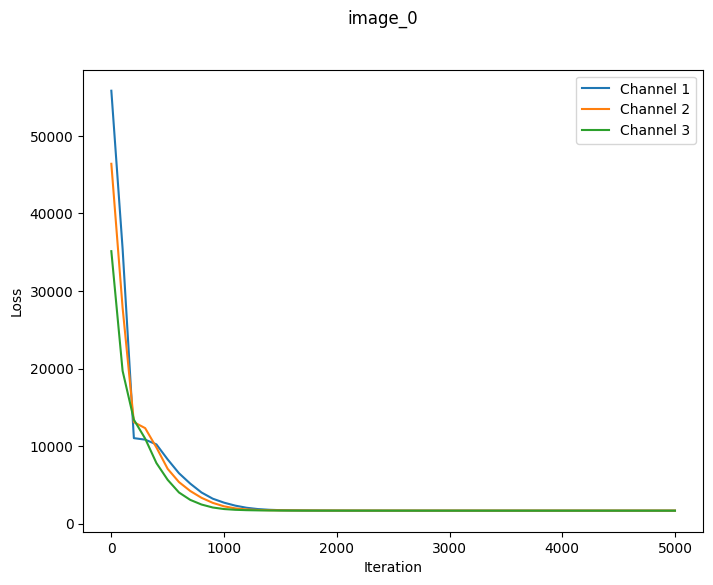

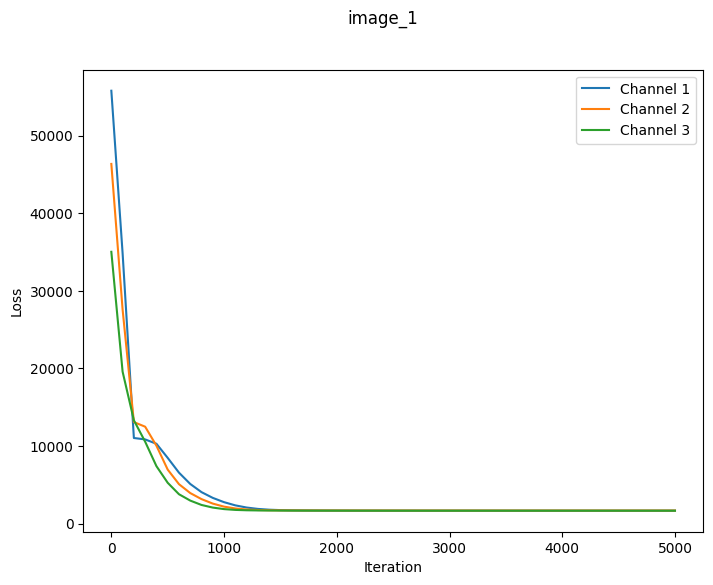

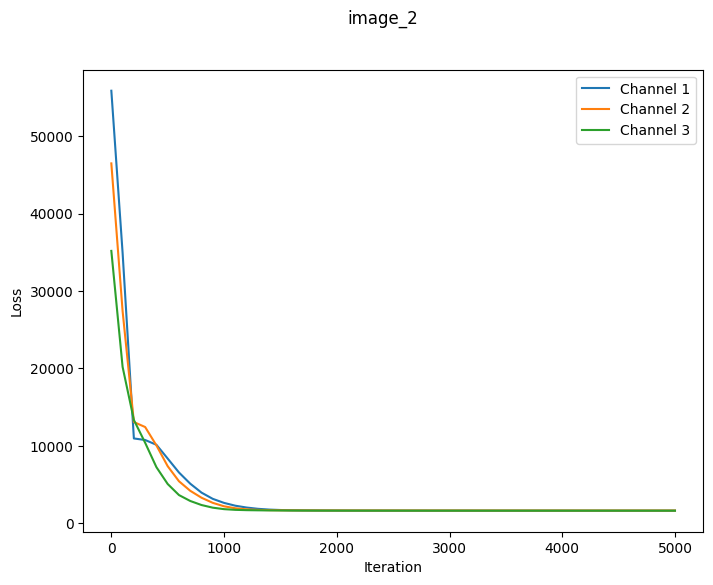

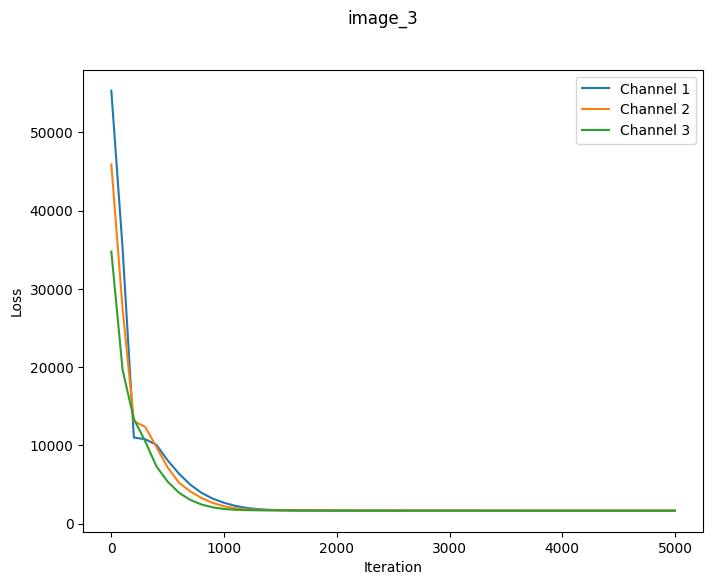

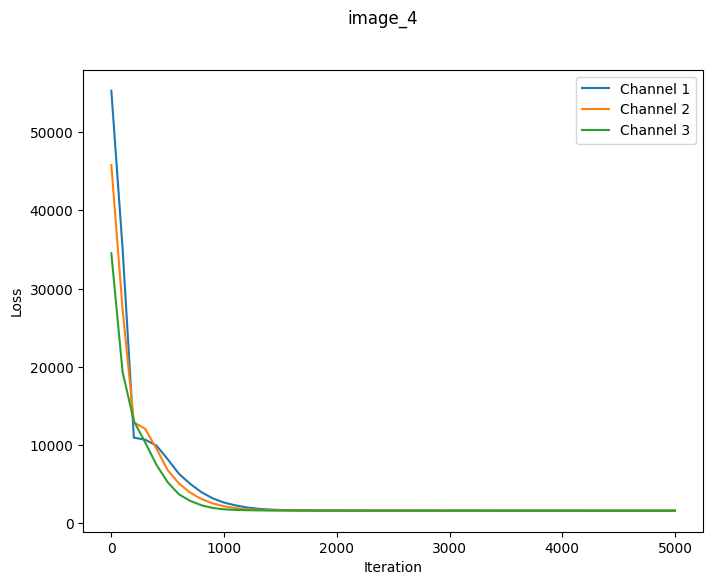

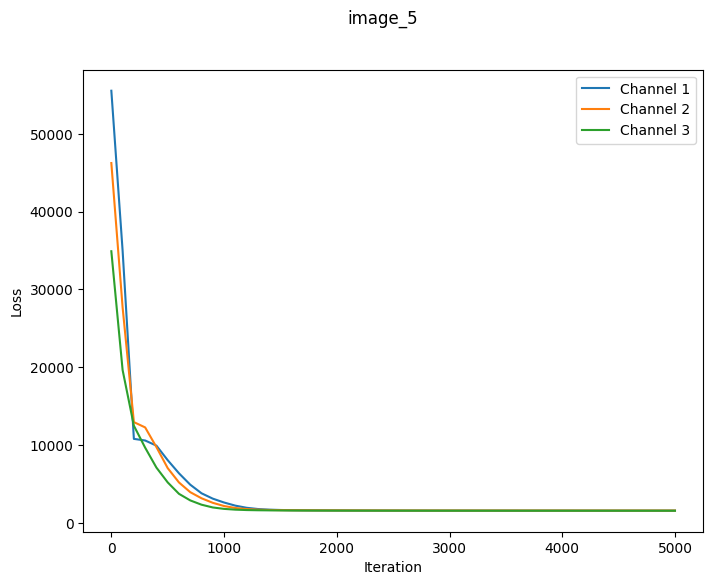

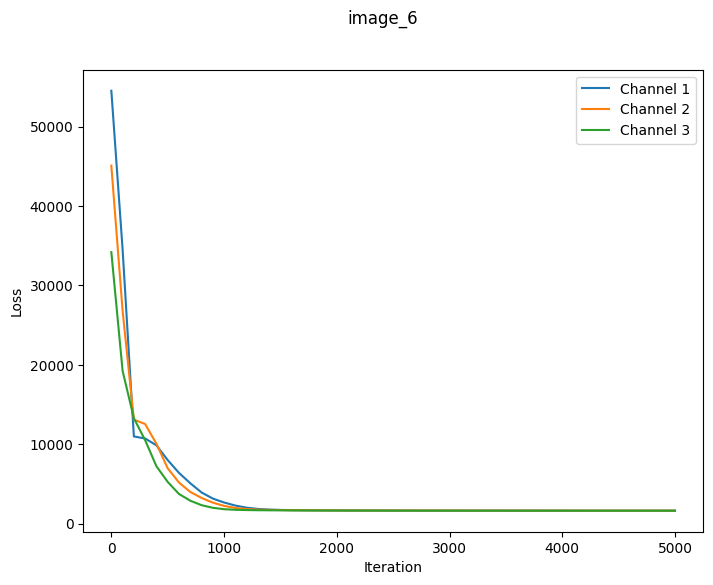

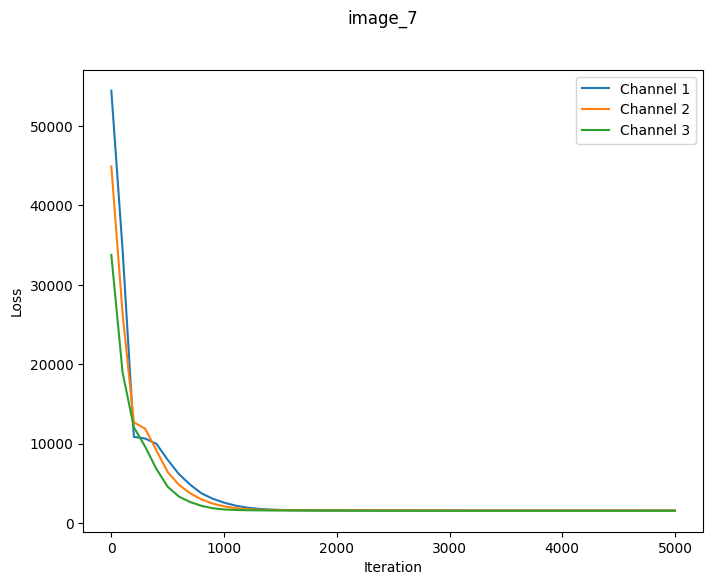

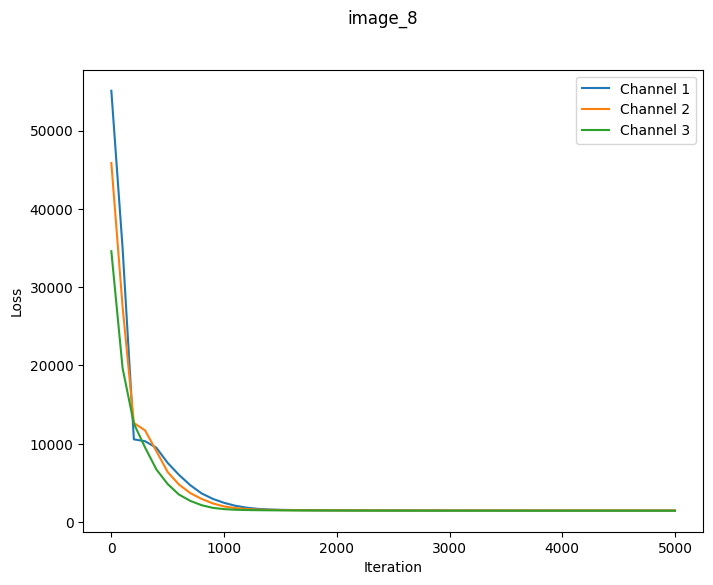

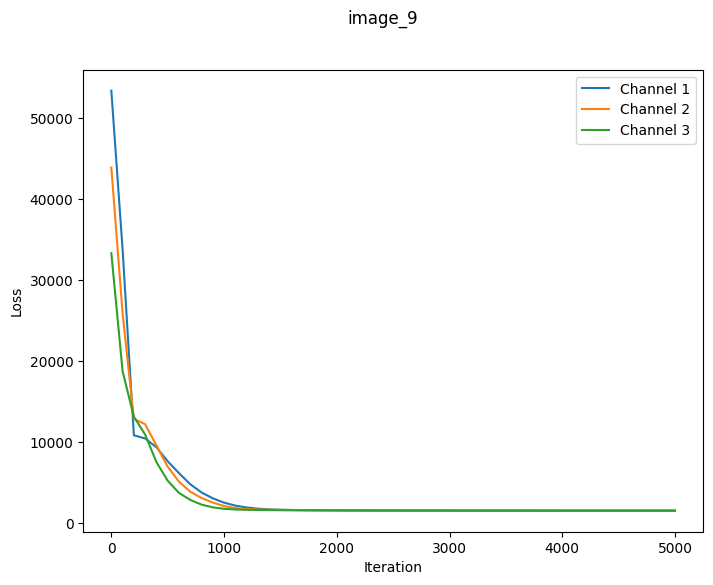

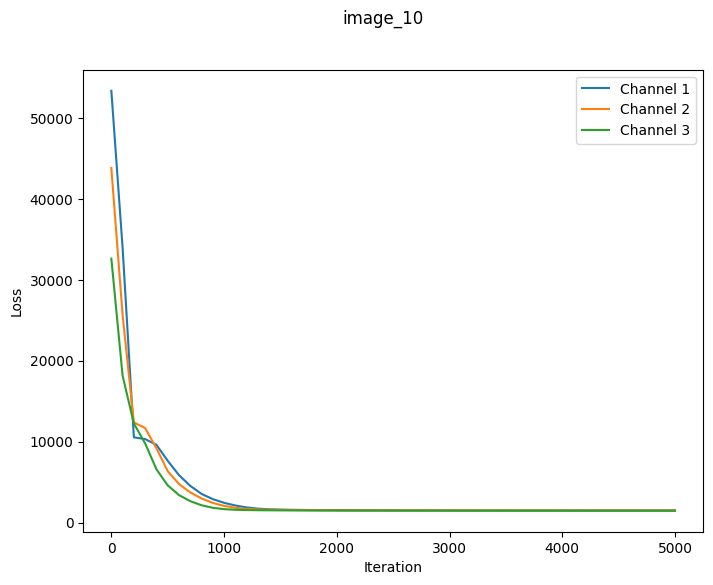

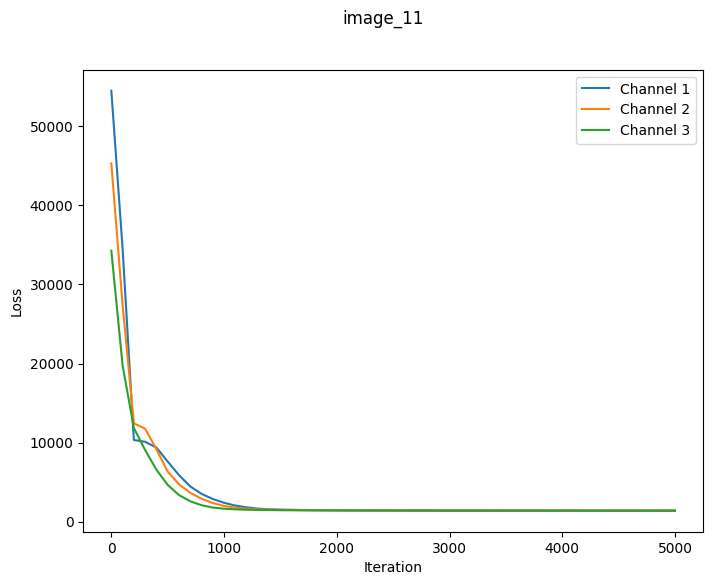

In [ ]:
num_images = len(gds)
print(num_images)
image_names = [f'image_{i}' for i in range(12)]
for i in range(num_images):
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f"{image_names[i]}")

    for j in range(3):  # Three channels
        channel_data = gds[i][j]
        iterations = [data[0] for data in channel_data]
        losses = [data[1].item() for data in channel_data]
        ax.plot(iterations, losses, label=f'Channel {j + 1}')

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.show()

## Comparision of the original image and genereated images
### How to do?
- Save images with different names
- Return the names list
- Also have the cropped images saved
- Write a function to compare the saven images in a loop
- Print the output

In [ ]:
def calculate_mse(original_image_path, image_list):
    # Read the original image
    original_image = io.imread(original_image_path)

    # Calculate MSE for each image in the list
    mse_values = []
    for image_path in image_list:
        current_image = io.imread(image_path)

        # Ensure both images have the same shape and data type
        current_image = np.asarray(current_image, dtype=original_image.dtype)

        # Calculate MSE
        mse = mean_squared_error(original_image, current_image)
        mse_values.append(mse)

    return mse_values

In [ ]:
def calculate_psnr(original_image_path, reconstructed_image_paths):
    # Read the original image
    original_image = io.imread(original_image_path)

    psnr_values = []

    for reconstructed_image_path in reconstructed_image_paths:
        # Read the reconstructed image
        reconstructed_image = io.imread(reconstructed_image_path)

        # Ensure both images have the same shape and data type
        reconstructed_image = np.asarray(reconstructed_image, dtype=original_image.dtype)

        # Calculate PSNR
        psnr = peak_signal_noise_ratio(original_image, reconstructed_image)
        psnr_values.append(psnr)

    return psnr_values


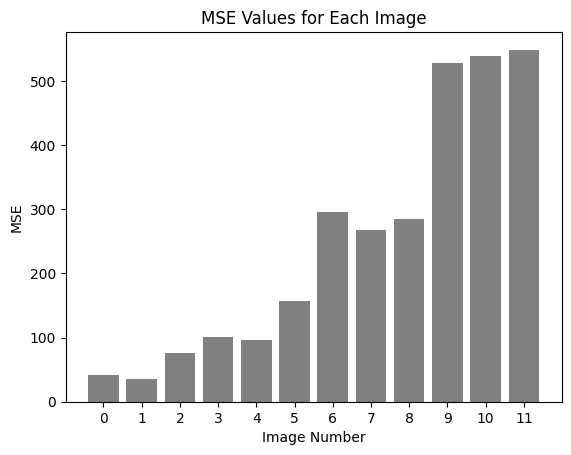

In [ ]:
mses = calculate_mse(original_image, reconstructed_images)
x_name_list = [f'{i}' for i in range(12)]
plt.bar(x_name_list, mses, color='gray')
plt.xlabel('Image Number')
plt.ylabel('MSE')
plt.title('MSE Values for Each Image')
plt.show()

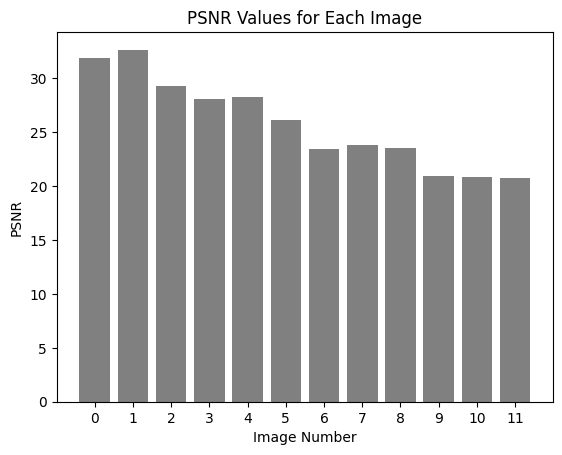

In [ ]:
psnr = calculate_psnr(original_image, reconstructed_images)
x_name_list = [f'{i}' for i in range(12)]
plt.bar(x_name_list, psnr, color='gray')
plt.xlabel('Image Number')
plt.ylabel('PSNR')
plt.title('PSNR Values for Each Image')
plt.show()

In [ ]:
def remove_pixels_from_image(img, num_pixels, seed=None):
    if seed is not None:
        random.seed(seed)

    img_copy = img.clone()
    height, width = img_copy.shape[-2], img_copy.shape[-1]

    # Randomly select pixels to remove
    pixels_to_remove = random.sample(range(height * width), num_pixels)
    rows = [pixel // width for pixel in pixels_to_remove]
    cols = [pixel % width for pixel in pixels_to_remove]

    img_copy[rows, cols] = float('nan')

    return img_copy

def remove_pixels_from_color_image(img, num_pixels, seed=None):
    masked_imgs = []
    for channel in range(img.shape[0]):
        channel_img = img[channel, :, :]
        channel_img = torch.tensor(channel_img, dtype=torch.float)
        masked_channel_img = remove_pixels_from_image(channel_img, num_pixels, seed)
        masked_imgs.append(masked_channel_img)
    masked_img = torch.stack(masked_imgs, dim=0)
    return masked_img

In [ ]:

masked_aplha = remove_pixels_from_color_image(crop, 900, 42)

<ipython-input-34-f4fff988f559>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel_img = torch.tensor(channel_img, dtype=torch.float)


In [ ]:
def run_for_number_of_pixels(crop, areas):
  original_image = ""
  reconstructed_images = []
  gds = []
  for area in areas:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    to_pil = torchvision.transforms.ToPILImage()
    timestamp_string = datetime.now().strftime("%Y%m%d%H%M%S")
    original_image = timestamp_string+"_original.jpg"

    pil_image = to_pil(crop)
    output_path = '/content/'+original_image
    pil_image.save(output_path)
    image = cv2.imread(output_path)

    height, width, _ = image.shape

    # Randomly select pixels to remove
    random.seed(7)
    pixels_to_remove = random.sample(range(height * width), area)
    rows = [pixel // width for pixel in pixels_to_remove]
    cols = [pixel % width for pixel in pixels_to_remove]

    image[rows, cols, :] = (0, 0, 0)

    img_np = crop.permute(1, 2, 0).numpy()

    axes[0].imshow(img_np)
    axes[0].axis('off')
    axes[0].set_title('Original Image')


    axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title(f'{area} pixels removed')

    masked_img = remove_pixels_from_color_image(crop, area, 7) # we have set the seed fixed to 7 for now
    timestamp_string = datetime.now().strftime("%Y%m%d%H%M%S")
    output_file_name = timestamp_string+".jpg"
    reconstructed_images.append(output_file_name)
    gds_each = factorize_color(masked_img, 40, torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), timestamp_string)
    gds.append(gds_each)

    img = torchvision.io.read_image("/content/"+output_file_name)
    img_np = img.permute(1, 2, 0).numpy()


    axes[2].imshow(img_np)
    axes[2].axis('off')
    axes[2].set_title(f'{area} pixels reconstructed')

    plt.tight_layout()

    plt.show()
  return gds, original_image, reconstructed_images

<ipython-input-34-f4fff988f559>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  channel_img = torch.tensor(channel_img, dtype=torch.float)


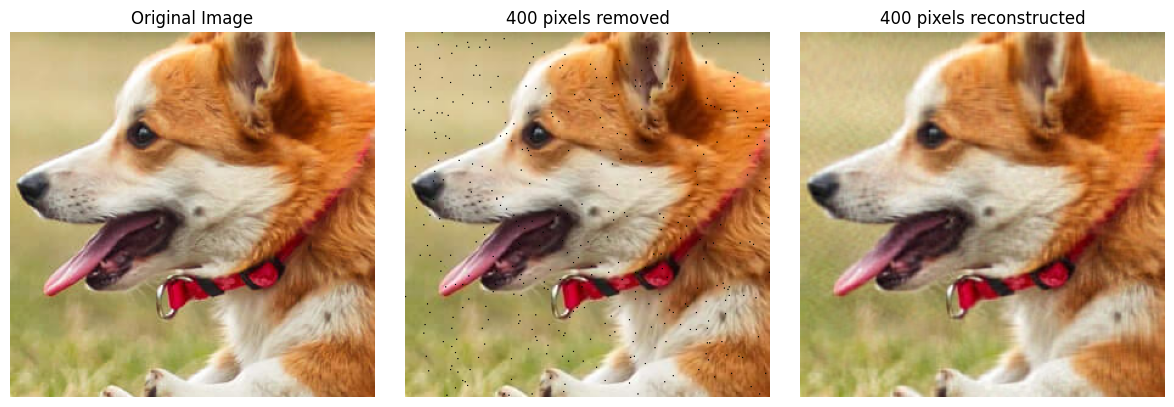

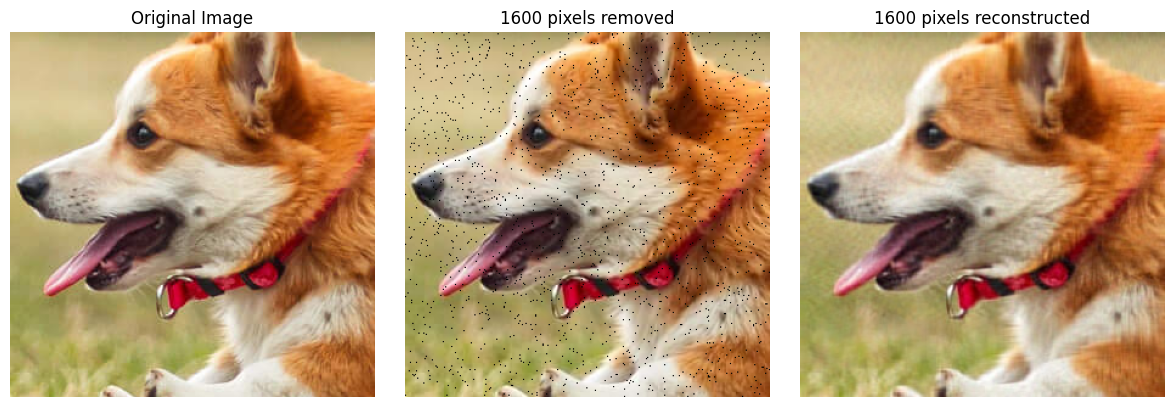

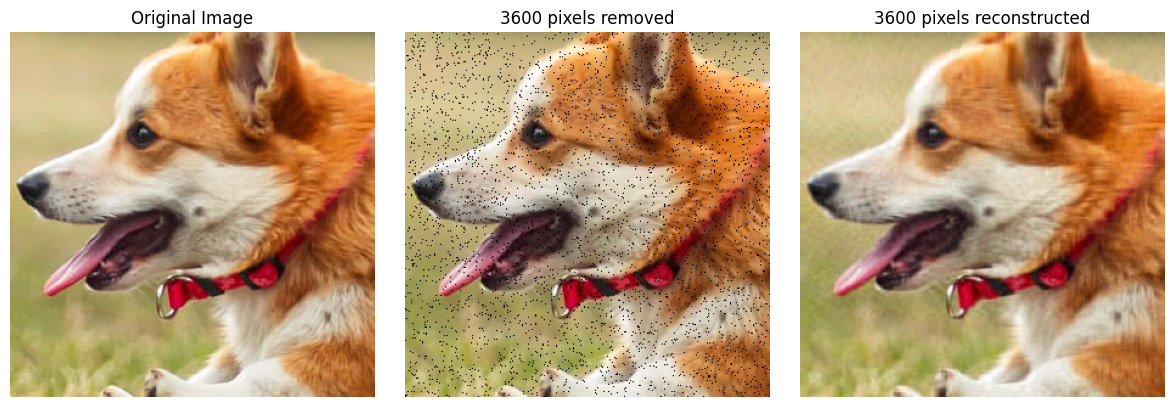

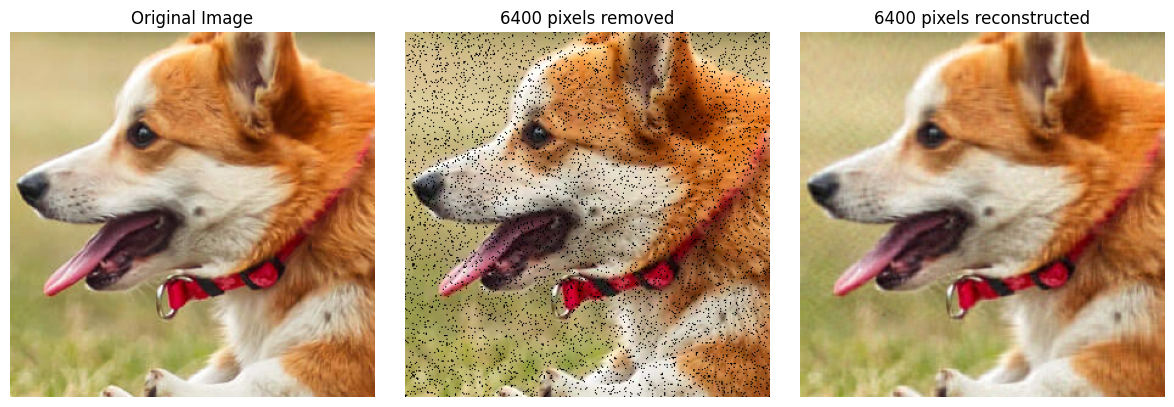

In [ ]:
areas = [400,1600,3600,6400]
gds2, original_2, reconstructed2 = run_for_number_of_pixels(crop, areas)

4


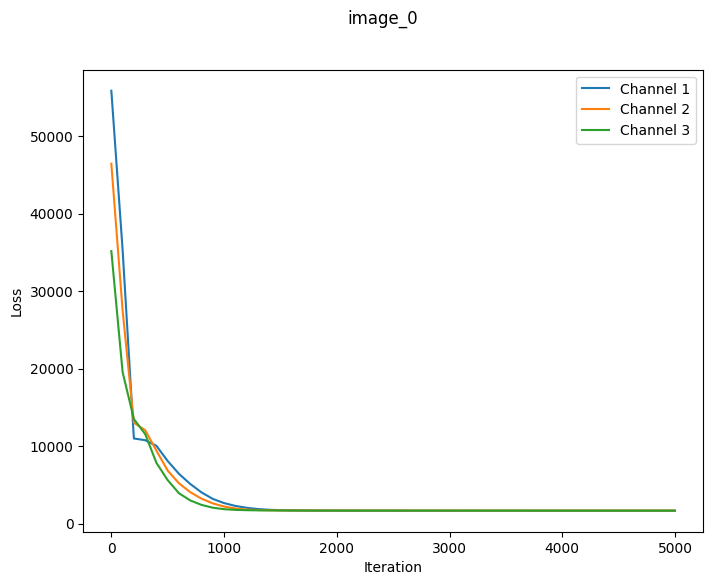

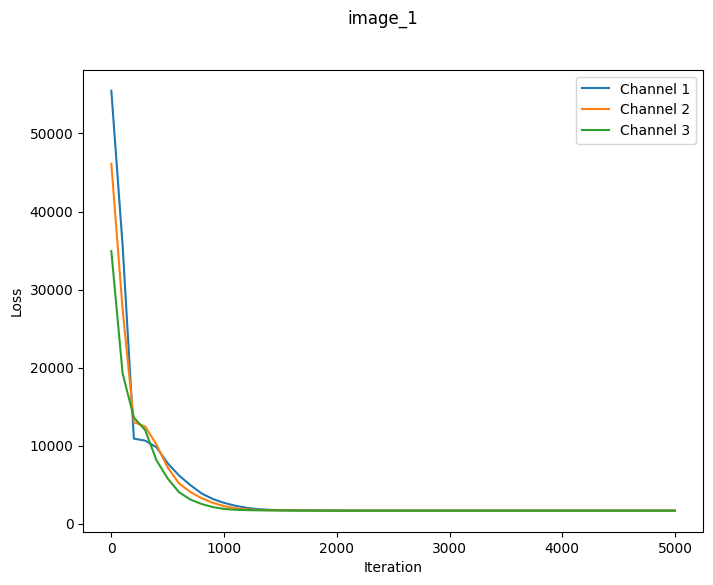

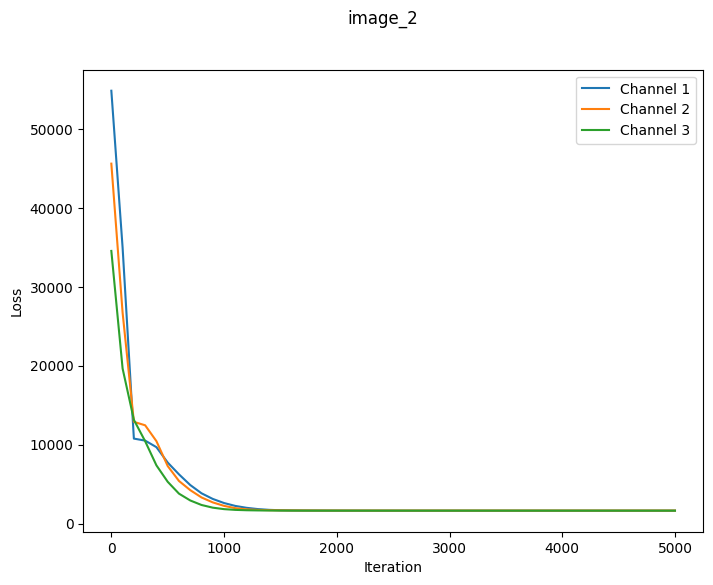

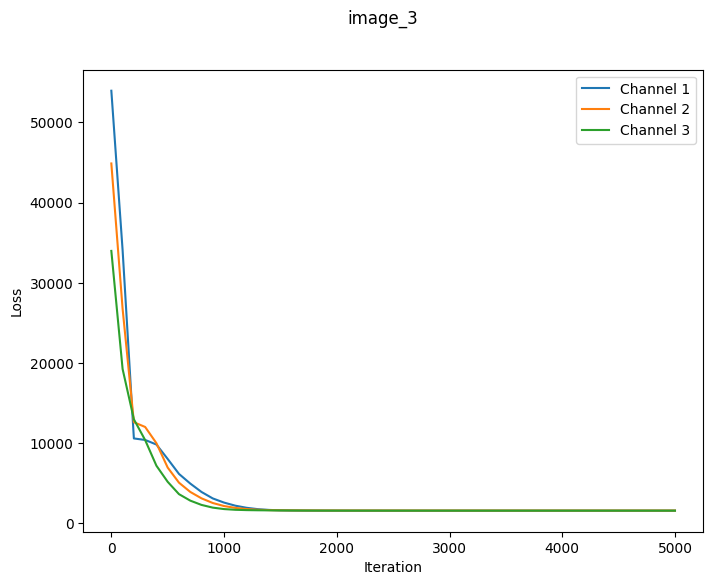

In [ ]:
num_images = len(gds2)
print(num_images)
image_names = [f'image_{i}' for i in range(12)]
for i in range(num_images):
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f"{image_names[i]}")

    for j in range(3):  # Three channels
        channel_data = gds2[i][j]
        iterations = [data[0] for data in channel_data]
        losses = [data[1].item() for data in channel_data]
        ax.plot(iterations, losses, label=f'Channel {j + 1}')

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.show()

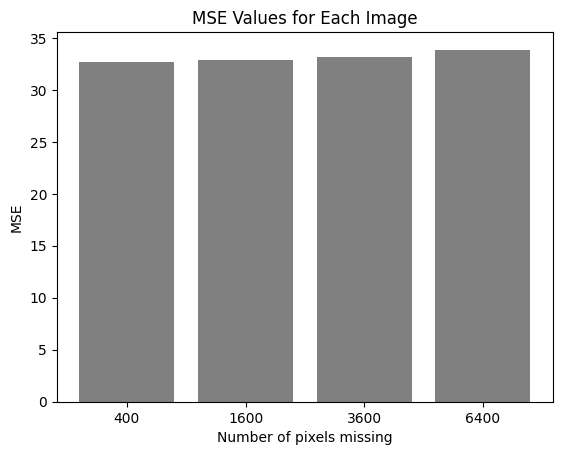

In [ ]:
mse3 = calculate_mse(original_2, reconstructed2)
x_name_list = ['400','1600','3600', '6400']
plt.bar(x_name_list, mse3, color='gray')
plt.xlabel('Number of pixels missing')
plt.ylabel('MSE')
plt.title('MSE Values for Each Image')
plt.show()

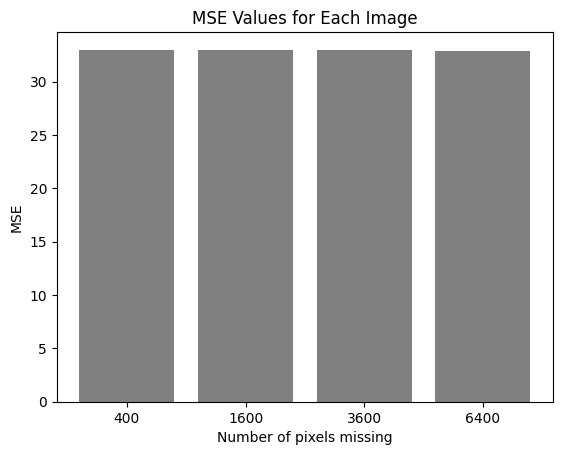

In [ ]:
psnr1 = calculate_psnr(original_2, reconstructed2)
x_name_list = ['400','1600','3600', '6400']
plt.bar(x_name_list, psnr1, color='gray')
plt.xlabel('Number of pixels missing')
plt.ylabel('MSE')
plt.title('MSE Values for Each Image')
plt.show()